In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install geopandas
import geopandas as gp
from statsmodels.graphics.tsaplots import plot_acf
import tqdm
plt.rcParams["figure.figsize"] = (11, 7)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
from pandas.api.types import is_string_dtype, is_numeric_dtype
import warnings
from pdb import set_trace
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
complaints_2021 = pd.read_csv('/content/drive/My Drive/Urban Computing/clustered_data.csv')
complaints_2021 = complaints_2021[['CMPLNT_START_DT', 'CRM_ATPT_CPTD_CD', 'Latitude', 'Longitude', 'Cluster_ID']]
# For now, setting LAW_CAT_CD (felony, misdemeanor, or violation) as class label. However, later will make 'OFNS_DESC', 'PD_DESC' as class label
# y = complaints_2021['LAW_CAT_CD']
# x=complaints_2021.drop('LAW_CAT_CD',axis=1)

In [ ]:
complaints_2021.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID
0,2021-12-31 18:20:00,COMPLETED,40.746775,-73.780867,2
1,2021-12-29 18:00:00,COMPLETED,40.784364,-73.912857,1
2,2021-12-21 18:30:00,COMPLETED,40.669258,-73.939430,1
3,2021-12-26 15:10:00,COMPLETED,40.727315,-73.997415,2
4,2021-12-26 18:00:00,COMPLETED,40.749755,-73.985615,2


In [ ]:
"Create many new columns based on datetime column."
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld,
                      infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('CMPLNT_START_DT$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek','Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end',
            'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) # 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def train_cats(df, cat_vars):
    # numercalize/categoricalize
    for name, col in df.items(): 
        if name in cat_vars:
            df[name] = col.cat.codes + 1
    df = pd.get_dummies(df, dummy_na=True)
    return df

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore',
             category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if
                 is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

#"Preprorocess the train, valid, test sets to numericalize,fillmissing, and normalize."
def proc_df(df, cat_vars, cont_vars, y_fld=None, do_scale=False,
           mapper=None, na_dict=None):
    
    ignore_flds=[]
    skip_flds=[]
    # set the dependent variable name and concatenate the cat and
    # cont
    dep_var = y_fld
    df = df[cat_vars + cont_vars + [dep_var]].copy()
    df[dep_var] = df[dep_var].astype(int)
    df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    y = df[y_fld].values
    # deal with skip fields
    skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    # initialize the na dictionary
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    # fill missing
    for name, col in df.items(): 
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+'_na'] = pd.isnull(col)
                filler = col.median()
                df[name] = col.fillna(filler)
                na_dict[name] = filler
    # keep track of which entries are missing and possibly use them
    # in the model
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) -
        set(na_dict_initial.keys()))], axis=1, inplace=True)
    # normalize
    if do_scale: mapper = scale_vars(df, mapper)
    res = [df, y, na_dict]
    # keep track of how things were normalized
    if do_scale: res = res + [mapper]
    return res

In [ ]:
add_datepart(complaints_2021, 'CMPLNT_START_DT', drop=False, time = True)

<ipython-input-32-58ed74a94e6d>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
<ipython-input-32-58ed74a94e6d>:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[targ_pre + 'Elapsed'] = fld.astype(np.int64) # 10 ** 9


In [ ]:
complaints_2021.columns

Index(['CMPLNT_START_DT', 'CRM_ATPT_CPTD_CD', 'Latitude', 'Longitude',
       'Cluster_ID', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Hour', 'Minute', 'Second', 'Elapsed'],
      dtype='object')

In [ ]:
#define the categorical and continuous variables
cat_vars = ['CRM_ATPT_CPTD_CD', 'Year', 'Month','Week', 'Day',
            'Dayofweek', 'Dayofyear', 'Is_month_end',
            'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
            'Is_year_end', 'Is_year_start', 'Hour', 'Minute', 'Second', 'Elapsed']
cont_vars = ['Latitude', 'Longitude']

In [ ]:
for v in cat_vars: complaints_2021[v] = complaints_2021[v].astype('category').cat.as_ordered()
df = train_cats(complaints_2021, cat_vars)

In [ ]:
complaints_2021.dtypes

CMPLNT_START_DT     datetime64[ns]
CRM_ATPT_CPTD_CD              int8
Latitude                   float64
Longitude                  float64
Cluster_ID                   int64
Year                          int8
Month                         int8
Week                          int8
Day                           int8
Dayofweek                     int8
Dayofyear                    int16
Is_month_end                  int8
Is_month_start                int8
Is_quarter_end                int8
Is_quarter_start              int8
Is_year_end                   int8
Is_year_start                 int8
Hour                          int8
Minute                        int8
Second                        int8
Elapsed                      int32
dtype: object

In [ ]:
for v in cat_vars: complaints_2021[v] = complaints_2021[v].astype('category').cat.as_ordered()
cat_sz = [(c, len(complaints_2021[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [ ]:
complaints_2021.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,Year,Month,Week,Day,Dayofweek,...,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Minute,Second,Elapsed
0,2021-12-31 18:20:00,2,40.746775,-73.780867,2,1,12,52,31,5,...,2,1,2,1,2,1,19,21,1,145405
1,2021-12-29 18:00:00,2,40.784364,-73.912857,1,1,12,52,29,3,...,1,1,1,1,1,1,19,1,1,144692
2,2021-12-21 18:30:00,2,40.669258,-73.939430,1,1,12,51,21,2,...,1,1,1,1,1,1,19,31,1,141748
3,2021-12-26 15:10:00,2,40.727315,-73.997415,2,1,12,51,26,7,...,1,1,1,1,1,1,16,11,1,143528
4,2021-12-26 18:00:00,2,40.749755,-73.985615,2,1,12,51,26,7,...,1,1,1,1,1,1,19,1,1,143576


In [ ]:
#split training and testing data sets
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
train, validate, test = np.split(complaints_2021.sample(frac=1, random_state=42), [int(.6*len(complaints_2021)), int(.8*len(complaints_2021))])

In [ ]:
train = train.drop(columns='CMPLNT_START_DT')
validate = validate.drop(columns='CMPLNT_START_DT')
test = test.drop(columns='CMPLNT_START_DT')

In [ ]:
print("shape of original dataset :", complaints_2021.shape)
print("shape of input - training set", train.shape)
print("shape of output - training set", test.shape)
print("shape of input - testing set", validate.shape)

shape of original dataset : (400380, 21)
shape of input - training set (240228, 20)
shape of output - training set (80076, 20)
shape of input - testing set (80076, 20)


In [ ]:
class ColumnarDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
       is_reg (bool): If the task is regression, set ``True``, 
                      otherwise (classification) ``False``.
       is_multi (bool): If the task is multi-label classification, 
                        set ``True``.
    """
    def __init__(self, df, cat_flds, y, is_reg, is_multi):
        df_cat = df[cat_flds]
        df_cont = df.drop(cat_flds, axis=1)
        
        cats = [c.values for n,c in df_cat.items()]
        conts = [c.values for n,c in df_cont.items()]
        
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y
        if is_reg: self.y =  self.y[:,None]
        self.is_reg = is_reg
        self.is_multi = is_multi
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [ ]:
dep_var = 'Cluster_ID'
x_train, y_train, nas, mapper = proc_df(train, cat_vars, cont_vars, dep_var, do_scale=True)
x_val, y_val, nas, mapper = proc_df(validate, cat_vars, cont_vars, dep_var, do_scale=True, mapper=mapper, na_dict=nas)
x_test, y_test, nas, mapper = proc_df(test, cat_vars, cont_vars, dep_var, do_scale=True)

In [ ]:
x_train.head()

,CRM_ATPT_CPTD_CD,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Minute,Second,Elapsed,Latitude,Longitude
59108,2,1,11,45,13,6,317,1,1,1,1,1,1,16,11,1,125567,1.027368,1.016101
179788,2,1,8,31,7,6,219,1,1,1,1,1,1,24,1,1,84301,-1.215015,-1.302453
331002,2,1,3,12,22,1,81,1,1,1,1,1,1,13,37,1,29588,-0.604626,2.226760
126984,2,1,9,37,16,4,259,1,1,1,1,1,1,3,31,1,100492,-0.140557,0.944957
51344,1,1,11,47,26,5,330,1,1,1,1,1,1,20,1,1,131136,-0.310528,0.161088


In [ ]:
trn_ds = ColumnarDataset(x_train, cat_vars, y_train, is_reg=True,is_multi=False)
val_ds = ColumnarDataset(x_val, cat_vars, y_val,is_reg=True,is_multi=False)
test_ds = ColumnarDataset(x_test, cat_vars, y_test,is_reg=True,is_multi=False)

bs = 64
train_dl = DataLoader(trn_ds, bs, shuffle=True)
val_dl = DataLoader(val_ds, bs, shuffle=False)
test_dl = DataLoader(test_ds, len(x_test), shuffle=False)

In [ ]:
class MixedInputModel(nn.Module):
    """Model able to handle inputs consisting of both categorical and continuous variables.
    Args:
       emb_szs (list of int): List of embedding size
       n_cont (int): Number of continuous variables in inputs
       emb_drop (float): Dropout applied to the output of embedding
       out_sz (int): Size of model's output.
       szs (list of int): List of hidden variables sizes
       drops (list of float): List of dropout applied to hidden 
                              variables
       y_range (list of float): Min and max of `y`. 
                                y_range[0] = min, y_range[1] = max.
       use_bn (bool): If use BatchNorm, set ``True``
       is_reg (bool): If regression, set ``True``
       is_multi (bool): If multi-label classification, set ``True``
    """
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, 
                 drops, y_range=None, use_bn=False, is_reg=True, 
                 is_multi=False):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, f"cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        if is_reg==False and is_multi==False: assert out_sz >= 2, "For classification with out_sz=1, use is_multi=True"
        self.embs = nn.ModuleList([nn.Embedding(c, s) 
                                      for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) 
                                        for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = torch.sigmoid(x)
            else:
                x = F.log_softmax(x, dim=1)
        elif self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)

In [ ]:
print(model)

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(13, 7)
    (3): Embedding(54, 27)
    (4): Embedding(32, 16)
    (5): Embedding(8, 4)
    (6): Embedding(366, 50)
    (7): Embedding(3, 2)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(25, 13)
    (14): Embedding(61, 31)
    (15): Embedding(2, 1)
    (16): Embedding(145492, 50)
  )
  (lins): ModuleList(
    (0): Linear(in_features=216, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04, inplace=False)
  (drops): ModuleList(
    (0): Dropout(p=0

In [ ]:
def train_model(model, train_dl, val_dl, n_epochs=1, lr=5e-2):
        "Run training loops."
        epochs = n_epochs
        opt = optim.SGD(model.parameters(), lr=lr)
        loss_func = nn.MSELoss()
        try:
            for epoch in range(epochs):
                model.train()
                for xb1, xb2, yb in train_dl:
                    preds = model(xb1, xb2)
                    loss = loss_func(preds, yb.float())
                    
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                    
                model.eval()
                with torch.no_grad():
                    loss_val = sum(loss_func(model(xv1, xv2), 
                                             yv.float()) 
                                   for xv1, xv2, yv in val_dl)
                print(epoch, loss_val / len(val_dl))
        except Exception as e:
            exception = e
            raise

In [ ]:
train_model(model, train_dl, val_dl, n_epochs=5, lr=5e-2)

0 tensor(0.6797)
1 tensor(0.6911)
2 tensor(0.6734)
3 tensor(0.6395)
4 tensor(0.6396)


In [ ]:
test.head()

,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Minute,Second,Elapsed
173324,2,40.712537,-74.011656,1,1,8,33,17,2,229,1,1,1,1,1,1,13,43,1,88225
370047,2,40.791290,-73.977560,2,1,2,5,5,5,36,1,1,1,1,1,1,7,21,1,12783
45822,2,40.680532,-73.915357,2,1,11,46,20,6,324,1,1,1,1,1,1,14,6,1,128546
205349,2,40.690866,-73.985848,1,1,7,29,23,5,204,1,1,1,1,1,1,19,24,1,78082
142526,2,40.857744,-73.915927,1,1,8,35,31,2,243,2,1,1,1,1,1,22,32,1,94249


In [ ]:
list_of_indexes_test = list(test.index.values)
print(list_of_indexes_test)

[173324, 370047, 45822, 205349, 142526, 311872, 59941, 297376, 301066, 51450, 321997, 191549, 281839, 365773, 119616, 59809, 328221, 178451, 83264, 381231, 282126, 41942, 251517, 192212, 355700, 215122, 71428, 379746, 294029, 288758, 99709, 217752, 315664, 150914, 296496, 325691, 26478, 353914, 147579, 310022, 66674, 105586, 302513, 351363, 325192, 303098, 331509, 70147, 197416, 165940, 346204, 140877, 371070, 177214, 316158, 278843, 191469, 226894, 157532, 397448, 66696, 22383, 33112, 183606, 388842, 367592, 155669, 235035, 124861, 227216, 25068, 326598, 251108, 187060, 190324, 170880, 172118, 113575, 167409, 33000, 369140, 248331, 178436, 154156, 112550, 216281, 264314, 123551, 9576, 109505, 302825, 340104, 79415, 49364, 117139, 336981, 200872, 94471, 13685, 38533, 335095, 40515, 283570, 14242, 116317, 100010, 211491, 198741, 62988, 184500, 139015, 42394, 126647, 312272, 317619, 229486, 347450, 167249, 136067, 382104, 307827, 230567, 105889, 123632, 391167, 159458, 272314, 262294, 11

In [ ]:
complaints_2021 = pd.read_csv('/content/drive/My Drive/Urban Computing/clustered_data.csv')
complaints_2021 = complaints_2021[['CMPLNT_START_DT', 'CRM_ATPT_CPTD_CD', 'Latitude', 'Longitude', 'Cluster_ID']]
test_human_readable = complaints_2021.loc[list_of_indexes_test].copy()

In [ ]:
test_human_readable.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1


In [ ]:
def predict_test(model, test_dl):
    "Returns predictions over test_df."
    model.eval()
    preds = [model(xv1, xv2) for xv1, xv2, _ in test_dl][0]
    targs = [yv for _, _, yv in test_dl][0]
    test_human_readable['targ_pred'] = preds.data.detach().numpy()
    return torch.argmax(preds, dim=1).data.detach().numpy(), test_human_readable

In [ ]:
preds, df = predict_test(model, test_dl)

In [ ]:
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,0.779106
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,1.289858
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.034345
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,1.229218
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,0.685213


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']

In [ ]:
print(f'RMSE: {np.sqrt(np.sum((predicted-actual)**2)/len(actual))}')

RMSE: 0.8014142801285897


In [ ]:
#calculate accuracy
from sklearn.metrics import accuracy_score
print(f'Accuracy of Deep NN: {accuracy_score(actual, predicted)}') 

Accuracy of Deep NN: 0.40422848294120584


In [ ]:
accuracy_list = []
accuracy_list.append(accuracy_score(actual, predicted))

In [ ]:
RMSE_list = []
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))


In [ ]:
train_model(model, train_dl, val_dl, n_epochs=10, lr=5e-2)

0 tensor(0.6286)
1 tensor(0.6555)
2 tensor(0.6428)
3 tensor(0.6725)
4 tensor(0.6859)
5 tensor(0.7114)
6 tensor(0.6998)
7 tensor(0.7135)
8 tensor(0.7109)
9 tensor(0.7154)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.373649
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,0.844574
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.133642
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,1.073890
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,0.934704


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']

In [ ]:
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=20, lr=5e-2)

0 tensor(0.6928)
1 tensor(0.6659)
2 tensor(0.6623)
3 tensor(0.6466)
4 tensor(0.6362)
5 tensor(0.6282)
6 tensor(0.6401)
7 tensor(0.6531)
8 tensor(0.6643)
9 tensor(0.6767)
10 tensor(0.6829)
11 tensor(0.7157)
12 tensor(0.7104)
13 tensor(0.6963)
14 tensor(0.6990)
15 tensor(0.7268)
16 tensor(0.7270)
17 tensor(0.7239)
18 tensor(0.7421)
19 tensor(0.7346)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.529969
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,0.983297
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.257703
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,1.236652
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,1.259593


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']

In [ ]:
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=5, lr=1e-2)

0 tensor(0.6023)
1 tensor(0.5992)
2 tensor(0.6071)
3 tensor(0.6011)
4 tensor(0.6010)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.082530
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,1.134624
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.128250
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,1.212846
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,1.188859


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=10, lr=1e-2)

0 tensor(0.7040)
1 tensor(0.6111)
2 tensor(0.5999)
3 tensor(0.6081)
4 tensor(0.6083)
5 tensor(0.5954)
6 tensor(0.6241)
7 tensor(0.5974)
8 tensor(0.6094)
9 tensor(0.6034)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.165222
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,0.950516
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,0.851963
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,0.897439
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,1.153943


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=20, lr=1e-2)

0 tensor(0.6317)
1 tensor(0.5950)
2 tensor(0.6069)
3 tensor(0.6204)
4 tensor(0.6236)
5 tensor(0.5995)
6 tensor(0.6106)
7 tensor(0.6116)
8 tensor(0.6011)
9 tensor(0.6212)
10 tensor(0.6095)
11 tensor(0.6158)
12 tensor(0.6199)
13 tensor(0.6107)
14 tensor(0.6130)
15 tensor(0.6219)
16 tensor(0.6253)
17 tensor(0.6279)
18 tensor(0.6417)
19 tensor(0.6603)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.769338
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,0.545985
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.156999
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,0.788564
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,1.826026


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=5, lr=1e-1)

0 tensor(0.6222)
1 tensor(0.6101)
2 tensor(0.6210)
3 tensor(0.6018)
4 tensor(0.6063)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.042783
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,0.858930
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.100276
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,0.980548
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,0.940684


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=10, lr=1e-1)

0 tensor(0.7303)
1 tensor(0.6318)
2 tensor(0.6007)
3 tensor(0.6124)
4 tensor(0.6313)
5 tensor(0.6238)
6 tensor(0.6336)
7 tensor(0.7411)
8 tensor(0.6746)
9 tensor(0.6912)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,0.886805
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,0.967650
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,0.674174
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,1.140807
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,1.237297


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
model = MixedInputModel(emb_szs, n_cont=len(x_train.columns)-len(cat_vars), emb_drop = 0.04, out_sz = 1, szs = [1000,500], drops = [0.001,0.01], y_range=(0,np.max(y_train)), use_bn=True, is_reg=True, is_multi=False)
train_model(model, train_dl, val_dl, n_epochs=20, lr=1e-1)

0 tensor(0.6491)
1 tensor(0.6091)
2 tensor(0.6279)
3 tensor(0.6074)
4 tensor(0.6087)
5 tensor(0.6172)
6 tensor(0.6398)
7 tensor(0.6569)
8 tensor(0.7506)
9 tensor(0.7187)
10 tensor(0.7064)
11 tensor(0.7118)
12 tensor(0.7070)
13 tensor(0.7086)
14 tensor(0.6870)
15 tensor(0.6984)
16 tensor(0.6999)
17 tensor(0.7012)
18 tensor(0.6902)
19 tensor(0.7145)


In [ ]:
preds, df = predict_test(model, test_dl)
df.head()

,CMPLNT_START_DT,CRM_ATPT_CPTD_CD,Latitude,Longitude,Cluster_ID,targ_pred
173324,2021-08-17 12:42:00,COMPLETED,40.712537,-74.011656,1,1.114921
370047,2021-02-05 06:20:00,COMPLETED,40.791290,-73.977560,2,1.027631
45822,2021-11-20 13:05:00,COMPLETED,40.680532,-73.915357,2,1.093757
205349,2021-07-23 18:23:00,COMPLETED,40.690866,-73.985848,1,1.171345
142526,2021-08-31 21:31:00,COMPLETED,40.857744,-73.915927,1,1.024845


In [ ]:
predicted = df['targ_pred'].round()
actual = df['Cluster_ID']
accuracy_list.append(accuracy_score(actual, predicted))
RMSE_list.append(np.sqrt(np.sum((predicted-actual)**2)/len(actual)))

In [ ]:
print(accuracy_list)
print(RMSE_list)

[0.40422848294120584, 0.39827164194015685, 0.3984839402567561, 0.41227084269943554, 0.4136195614166542, 0.4068385034217493, 0.41229581897197665, 0.40041960137869026, 0.4043783405764524]
[0.8014142801285897, 0.8881585532240953, 0.8898161696805506, 0.7798619906827835, 0.7798860102095212, 0.823502126309074, 0.7823241466828447, 0.8630569946375539, 0.8703550183889716]


In [ ]:
epochs_list = [5, 10, 20]
lr_list = [0.01, 0.05, 0.1]

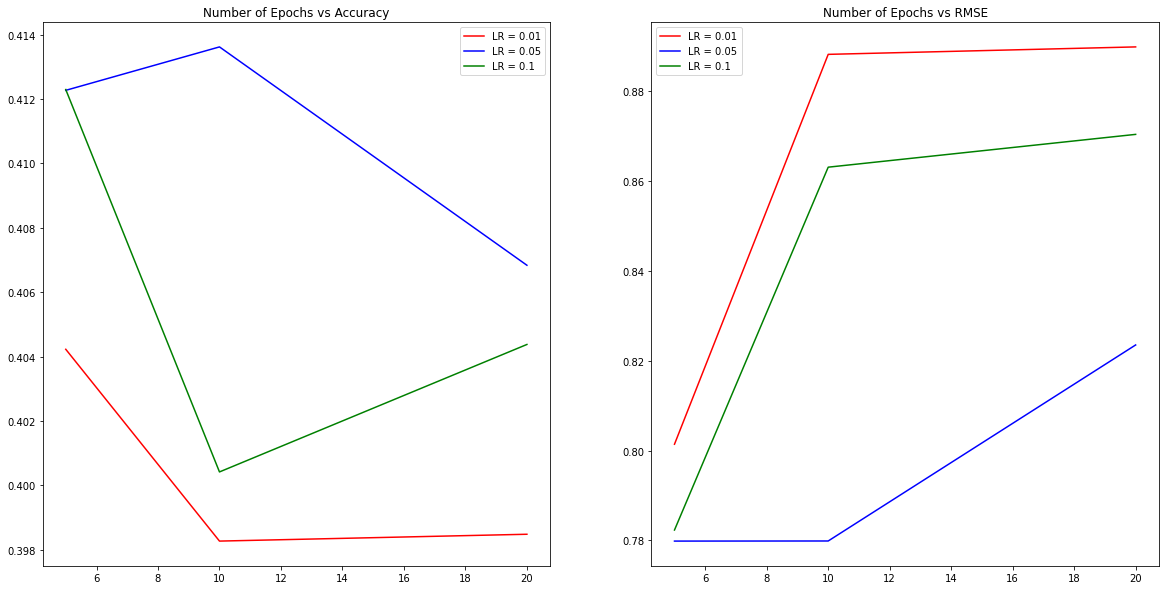

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10)
figure, axis = plt.subplots(1,2)

axis[0].plot(epochs_list, accuracy_list[0:3], color='r', label='LR = 0.01')
axis[0].plot(epochs_list, accuracy_list[3:6], color='b', label='LR = 0.05')
axis[0].plot(epochs_list, accuracy_list[6:9], color='g', label='LR = 0.1')
axis[0].set_title("Number of Epochs vs Accuracy")

axis[1].plot(epochs_list, RMSE_list[0:3], color='r', label='LR = 0.01')
axis[1].plot(epochs_list, RMSE_list[3:6], color='b', label='LR = 0.05')
axis[1].plot(epochs_list, RMSE_list[6:9], color='g', label='LR = 0.1')
axis[1].set_title("Number of Epochs vs RMSE")

axis[0].legend()
axis[1].legend()